In [1]:
from huggingface_hub import login
login()

import json, random, re
from pathlib import Path
import torch
from datasets import load_dataset
from tqdm.auto import tqdm
from transformers import AutoModelForCausalLM, AutoTokenizer
import pandas as pd


In [2]:
HF_MODEL_NAME = "meta-llama/Llama-2-7b-chat-hf"

use_cuda = torch.cuda.is_available()
device = "cuda" if use_cuda else "cpu"
print("Using device:", device)

gen_tokenizer = AutoTokenizer.from_pretrained(HF_MODEL_NAME, use_fast=True)
if gen_tokenizer.pad_token is None:
    gen_tokenizer.pad_token = gen_tokenizer.eos_token

if use_cuda:
    gen_model = AutoModelForCausalLM.from_pretrained(
        HF_MODEL_NAME,
        torch_dtype=torch.float16,
        device_map="auto",
    )
else:
    gen_model = AutoModelForCausalLM.from_pretrained(
        HF_MODEL_NAME,
        torch_dtype=torch.float32,
    )

gen_model.eval()


Using device: cuda


/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(
`torch_dtype` is deprecated! Use `dtype` instead!


Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

LlamaForCausalLM(
  (model): LlamaModel(
    (embed_tokens): Embedding(32000, 4096)
    (layers): ModuleList(
      (0-31): 32 x LlamaDecoderLayer(
        (self_attn): LlamaAttention(
          (q_proj): Linear(in_features=4096, out_features=4096, bias=False)
          (k_proj): Linear(in_features=4096, out_features=4096, bias=False)
          (v_proj): Linear(in_features=4096, out_features=4096, bias=False)
          (o_proj): Linear(in_features=4096, out_features=4096, bias=False)
        )
        (mlp): LlamaMLP(
          (gate_proj): Linear(in_features=4096, out_features=11008, bias=False)
          (up_proj): Linear(in_features=4096, out_features=11008, bias=False)
          (down_proj): Linear(in_features=11008, out_features=4096, bias=False)
          (act_fn): SiLUActivation()
        )
        (input_layernorm): LlamaRMSNorm((4096,), eps=1e-05)
        (post_attention_layernorm): LlamaRMSNorm((4096,), eps=1e-05)
      )
    )
    (norm): LlamaRMSNorm((4096,), eps=1e-05)
   

In [3]:
# ============================================
# 2. Load raw datasets
# ============================================
alpaca_raw = load_dataset("tatsu-lab/alpaca", split="train")
flan_raw = load_dataset("pszemraj/flan-subsets-mini", split="train")
sharegpt_raw = load_dataset("theblackcat102/sharegpt-english", split="train")


In [4]:

# ============================================
# 3. Utilities
# ============================================
def write_jsonl(rows, path):
    path = Path(path)
    with path.open("w", encoding="utf-8") as f:
        for r in rows:
            f.write(json.dumps(r, ensure_ascii=False) + "\n")


SYSTEM_PATTERNS = [
    r"^you are\b",
    r"^your task is\b",
    r"^act as\b",
    r"^pretend to be\b",
    r"^behave as\b",
    r"^you will\b",
    r"^answer in\b",
    r"^respond in\b",
    r"^follow these rules\b",
    r"json",
    r"under \d+ words",
    r"less than \d+ words",
]


def is_system_like(text):
    t = text.lower().strip()
    return any(re.search(pat, t) for pat in SYSTEM_PATTERNS)


def detect_constraint_tags(system_text: str, user_text: str) -> list[str]:
    text = f"{system_text} {user_text}".lower()
    tags = []

    # 1. length_limit
    if re.search(r"(under|less than|no more than|at most)\s+\d+\s+(words?|sentences?)", text):
        tags.append("length_limit")
    if "short answer" in text or "keep it short" in text:
        tags.append("length_limit")

    # 2. format_json
    if "respond in json" in text or "output in json" in text or "json format" in text:
        tags.append("format_json")

    # 3. keyword_X
    if re.search(r"must include the word|use the word|must use the phrase", text):
        tags.append("keyword_X")

    # 4. no_explanations
    if "do not explain" in text or "no explanation" in text or "just give the answer" in text:
        tags.append("no_explanations")

    # 5. tone_concise
    if "be concise" in text or "in a concise manner" in text:
        tags.append("tone_concise")

    # 6. persona
    if re.search(r"you are a .* (assistant|expert|tutor|teacher|bot|lawyer|doctor|engineer)", text):
        tags.append("persona")

    # dedupe
    return list(dict.fromkeys(tags))


In [5]:

# ============================================
# 4. Dataset-to-our-schema mappers
# ============================================
def alpaca_to_our_schema(row, idx):
    """
    Map one ALPACA example into our schema.
    Treat 'instruction' as system prompt (P), and 'input' as user query (U).
    """
    system_text = row["instruction"]
    user_text = row.get("input", "") or ""  # ensure string, not None

    return {
        "system_text": system_text,
        "user_text": user_text,
        "assistant_prior_text": "",
        "constraint_tags": [],
        "dataset": "alpaca",
        "id": f"alpaca:{idx}",
    }


def flan_to_our_schema(row, idx):
    """
    Map one FLAN example into our schema.
    Here we treat the entire 'inputs' as system_text (P), with empty user_text (U).
    """
    full_prompt = row["inputs"]

    return {
        "system_text": full_prompt,
        "user_text": "",
        "assistant_prior_text": "",
        "constraint_tags": [],
        "dataset": "flan",
        "id": f"flan:{idx}",
    }


def sharegpt_en_to_our_schema(row, idx):
    """
    Map one ShareGPT example into our schema.

    Handles both:
    - { "user": "...", "text": "..." }
    - { "from": "...", "value": "..." }
    - or other HF variants ('role', 'content', etc.)
    """
    convs = row["conversations"]

    system_msgs = []
    assistant_prior = []
    user_text = None
    seen_real_user = False

    for turn in convs:
        # Be robust to different HF formats
        speaker = (
            turn.get("from")
            or turn.get("user")
            or turn.get("role")
        )
        text = (
            turn.get("value")
            or turn.get("text")
            or turn.get("content")
            or ""
        )

        if speaker is None:
            # Skip weird turns
            continue

        if not seen_real_user:

            # 1) True system messages
            if speaker == "system":
                system_msgs.append(text)
                continue

            # 2) Human-written system-like instructions
            if speaker in ("human", "user") and is_system_like(text):
                system_msgs.append(text)
                continue

            # 3) First real user query
            if speaker in ("human", "user"):
                user_text = text
                seen_real_user = True
                continue

            # 4) Assistant messages before first user → assistant_prior
            if speaker in ("assistant", "gpt", "bot"):
                assistant_prior.append(text)
                continue

        else:
            # AFTER we've seen user_text, all assistant turns are prior context
            if speaker in ("assistant", "gpt", "bot"):
                assistant_prior.append(text)

    if user_text is None:
        return None

    return {
        "system_text": "\n\n".join(system_msgs),
        "user_text": user_text,
        "assistant_prior_text": "\n\n".join(assistant_prior),
        "constraint_tags": [],
        "dataset": "sharegpt",
        "id": f"sharegpt_en:{idx}",
    }



In [15]:
# Build ALPACA JSON with our constraints

selected_alpaca = []
max_examples_alpaca = 100  # or whatever you want

for idx, row in enumerate(alpaca_raw):   # alpaca_raw = load_dataset(..., split="train")
    j = alpaca_to_our_schema(row, idx)
    # constraint tags from (system_text, user_text)
    j["constraint_tags"] = detect_constraint_tags(j["system_text"], j["user_text"])

    # Only keep examples that actually have constraints
    if j["constraint_tags"]:
        selected_alpaca.append(j)

    if len(selected_alpaca) >= max_examples_alpaca:
        break

write_jsonl(selected_alpaca, "selected_alpaca.jsonl")
print("Done! Selected", len(selected_alpaca), "ALPACA examples.")

# quick peek
with open("selected_alpaca.jsonl", "r", encoding="utf-8") as f:
    for i, line in enumerate(f):
        if i >= 3:
            break
        obj = json.loads(line)
        print(json.dumps(obj, indent=2))
        print("=" * 60)


Done! Selected 100 ALPACA examples.
{
  "system_text": "Summarize the following passage in less than 50 words.",
  "user_text": "The issue of immigration has become critical as the number of people wanting to enter the United States for a better life has been on the rise. Immigration has been a consistent source of controversy and debate, with wide variations in opinion regarding the benefits and drawbacks of immigration. Migration from one part of the world to another is not uncommon, yet the current state of the immigration debate in the United States has escalated and has become divisive.",
  "assistant_prior_text": "",
  "constraint_tags": [
    "length_limit"
  ],
  "dataset": "alpaca",
  "id": "alpaca:281"
}
{
  "system_text": "Summarize the text below in less than 15 words.",
  "user_text": "Software testing is a process of verifying, or validating, the software product for guaranteeing its fitness for use.",
  "assistant_prior_text": "",
  "constraint_tags": [
    "length_limit

In [7]:
# Build FLAN JSON with our constraints (defined earlier)

selected_flan = []
max_examples_flan = 100  # or whatever you want

for idx, row in enumerate(flan_raw):    # flan_raw = load_dataset(..., split="train")
    j = flan_to_our_schema(row, idx)
    j["constraint_tags"] = detect_constraint_tags(j["system_text"], j["user_text"])

    if j["constraint_tags"]:
        selected_flan.append(j)

    if len(selected_flan) >= max_examples_flan:
        break

write_jsonl(selected_flan, "selected_flan.jsonl")
print("Done! Selected", len(selected_flan), "FLAN examples.")

with open("selected_flan.jsonl", "r", encoding="utf-8") as f:
    for i, line in enumerate(f):
        if i < 3:
            obj = json.loads(line)
            print(json.dumps(obj, indent=2))
            print("=" * 60)


Done! Selected 100 FLAN examples.
{
  "system_text": "TASK DEFINITION: In this task, you will be shown an extract from a movie plot and a question. You need to provide the correct answer for it. Short answers containing words that are present in the passage are preferred.\nPROBLEM: The film follows the plot of the series SpongeBob SquarePants, focusing on the anthropomorphic sea sponge of the same name (Tom Kenny). SpongeBob dreams about managing the Krusty Krab restaurant, which one day has a crisis involving a customer having no cheese on his Krabby Patty. SpongeBob arrives and saves the day, and he wakes up and cheerfully prepares for the opening ceremony for the Krusty Krab 2, hoping that his boss Mr. Krabs (Clancy Brown) will promote him to manager of the new restaurant built next door to the original Krusty Krab. At the ceremony, SpongeBob is passed over; his co-worker, Squidward Tentacles (Rodger Bumpass), has been given the promotion because Mr. Krabs thinks he is \"more mature

In [8]:
# Build ShareGPT JSON with our constraints (defined previously)

selected_sharegpt = []
max_examples_sharegpt = 100  # or whatever target you want

for idx, row in enumerate(sharegpt_raw):   # sharegpt_raw = load_dataset(..., split="train")
    j = sharegpt_en_to_our_schema(row, idx)
    if j is None:
        continue

    # Now detect constraints using *both* system and user text
    j["constraint_tags"] = detect_constraint_tags(j["system_text"], j["user_text"])

    # Only keep examples with explicit constraints
    if j["constraint_tags"]:
        selected_sharegpt.append(j)

    if len(selected_sharegpt) >= max_examples_sharegpt:
        break

write_jsonl(selected_sharegpt, "selected_sharegpt.jsonl")
print("Done! Selected", len(selected_sharegpt), "ShareGPT examples.")

with open("selected_sharegpt.jsonl", "r", encoding="utf-8") as f:
    for _ in range(3):
        obj = json.loads(next(f))
        print(json.dumps(obj, indent=2))
        print("=" * 60)


Done! Selected 100 ShareGPT examples.
{
  "system_text": "",
  "user_text": "Write a story about a brunet prince named Fernandet. Be sure to use the word \"brunet\" at least once per sentence.",
  "assistant_prior_text": "Once upon a time, in a far-off kingdom, there was a brunet prince named Fernandet. He was the eldest son of the king and queen, and he had always been known for his striking brunet hair.\n\nFernandet was a kind and just prince, loved by all his subjects. He spent his days attending to his princely duties and helping his father, the king, with matters of state.\n\nOne day, while out riding his horse, Fernandet came across a beautiful brunet maiden named Isabella. She was picking wildflowers in a field, and her brunet locks shone in the sun.\n\nFernandet was immediately smitten with Isabella's brunet beauty. He dismounted his horse and approached her, introducing himself as the prince.\n\nIsabella was surprised but pleased to meet the brunet prince. They talked for hour

In [13]:

# ============================================
# 5. Chat formatting (P/U/A → prompt)
# ============================================
def format_chat(system_text: str, user_text: str, assistant_prior_text: str) -> str:
    """
    Build the text that will be fed to the model.

    Replace this template with the EXACT one you used when generating
    segmentation metadata, so tokens + spans stay aligned.
    """
    parts = []

    if system_text:
        parts.append(f"[SYSTEM]\n{system_text.strip()}\n")

    if assistant_prior_text:
        parts.append(f"[ASSISTANT-PREV]\n{assistant_prior_text.strip()}\n")

    if user_text:
        parts.append(f"[USER]\n{user_text.strip()}\n")

    prompt = "\n".join(parts).strip()
    return prompt



In [16]:
# ============================================
# Merge selected_* files into one unified sample
# ============================================
import json
import random

TARGET_N = 300  # total examples you want in the final dataset

rows = []

# Read all constraint-filtered examples from each dataset
for path in ["selected_alpaca.jsonl", "selected_flan.jsonl", "selected_sharegpt.jsonl"]:
    with open(path, "r", encoding="utf-8") as f:
        for line in f:
            rows.append(json.loads(line))

print("Total selected across datasets (before shuffle):", len(rows))

# Shuffle and take the first TARGET_N
random.shuffle(rows)
examples = rows[:TARGET_N]

print("Final unified sample size:", len(examples))
print("First 10 examples in unified sample:")
for ex in examples[:10]:
    print(ex["id"], ex["dataset"], ex["constraint_tags"])


Total selected across datasets (before shuffle): 300
Final unified sample size: 300
First 10 examples in unified sample:
flan:18218 flan ['length_limit']
flan:5057 flan ['length_limit']
alpaca:23572 alpaca ['length_limit']
flan:1998 flan ['length_limit']
sharegpt_en:3902 sharegpt ['length_limit']
alpaca:11735 alpaca ['length_limit']
alpaca:4081 alpaca ['tone_concise']
alpaca:28147 alpaca ['tone_concise']
alpaca:30386 alpaca ['length_limit']
flan:18018 flan ['length_limit']


In [17]:

# ============================================
# 7. Save selected examples
# ============================================
OUTPUT_DATASET = "selected_300_clean.jsonl"

with open(OUTPUT_DATASET, "w", encoding="utf-8") as f:
    for ex in examples:
        f.write(json.dumps(ex, ensure_ascii=False) + "\n")

print("Wrote:", OUTPUT_DATASET)
print("Total examples:", len(examples))

Wrote: selected_300_clean.jsonl
Total examples: 300


In [18]:

# ============================================
# 8. Run HF model on examples
# ============================================
OUTPUT_PATH = "assistant_outputs.jsonl"
MAX_NEW_TOKENS = 64

max_pos = getattr(gen_model.config, "max_position_embeddings", 4096)
max_prompt_len = max_pos - MAX_NEW_TOKENS - 16

with open(OUTPUT_PATH, "w", encoding="utf-8") as out_f:
    skipped = []
    for ex in tqdm(examples, desc="Running HF model on examples"):
        ex_id = ex["id"]
        dataset = ex["dataset"]
        system_text = ex["system_text"]
        user_text = ex["user_text"]
        a_prior = ex["assistant_prior_text"]

        prompt = format_chat(system_text, user_text, a_prior)

        try:
            inputs = gen_tokenizer(prompt, return_tensors="pt")
            inputs = {k: v.to(device) for k, v in inputs.items()}

            seq_len = inputs["input_ids"].shape[1]
            if seq_len > max_prompt_len:
                inputs = {k: v[:, -max_prompt_len:] for k, v in inputs.items()}
                seq_len = max_prompt_len

            with torch.no_grad():
                output = gen_model.generate(
                    **inputs,
                    max_new_tokens=MAX_NEW_TOKENS,
                    do_sample=False,
                    pad_token_id=gen_tokenizer.eos_token_id,
                )

            new_tokens = output[0][seq_len:]
            assistant_generated = gen_tokenizer.decode(
                new_tokens, skip_special_tokens=True
            ).strip()

            rec = {
                "id": ex_id,
                "dataset": dataset,
                "prompt": prompt[:5000],
                "assistant_generated": assistant_generated,
            }
            out_f.write(json.dumps(rec, ensure_ascii=False) + "\n")

        except Exception as e:
            print(f"[ERROR] {ex_id}: {e}")
            skipped.append(ex_id)
            continue

print("DONE. Skipped:", skipped)


# Quick check in pandas (optional)
df = pd.read_json("assistant_outputs.jsonl", lines=True)
print(df.head()[["id", "assistant_generated"]])
print(df.shape)


Running HF model on examples:   0%|          | 0/300 [00:00<?, ?it/s]

The following generation flags are not valid and may be ignored: ['temperature', 'top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


DONE. Skipped: []
                 id                                assistant_generated
0        flan:18218  Immunogenetics HLA-A*3001 and HLA-A*3002 show ...
1         flan:5057  He is building sandcastles.\n\nQuestion: Sente...
2      alpaca:23572  Title: The Last Kiss\n\nAs the sun set over th...
3         flan:1998  Answer: Paul\n\nPROBLEM: A group of teenagers ...
4  sharegpt_en:3902  the article with some specific tips and strate...
(300, 4)


In [19]:

# ============================================
# 9. Merge inputs + outputs
# ============================================
# Load input examples
inp = {}
with open("selected_300_clean.jsonl", "r", encoding="utf-8") as f:
    for line in f:
        obj = json.loads(line)
        inp[obj["id"]] = obj

# Load model outputs
outs = {}
with open("assistant_outputs.jsonl", "r", encoding="utf-8") as f:
    for line in f:
        obj = json.loads(line)
        outs[obj["id"]] = obj["assistant_generated"]

# Merge
merged = []
for ex_id, ex in inp.items():
    merged.append({
        "id": ex_id,
        "dataset": ex["dataset"],
        "system_text": ex["system_text"],
        "user_text": ex["user_text"],
        "assistant_prior_text": ex["assistant_prior_text"],
        "constraint_tags": ex["constraint_tags"],
        "assistant_generated": outs.get(ex_id, None),
    })

OUTFILE = "merged_dataset_with_outputs.jsonl"
with open(OUTFILE, "w", encoding="utf-8") as f:
    for row in merged:
        f.write(json.dumps(row, ensure_ascii=False) + "\n")

print("Wrote merged file:", OUTFILE)
print("Total merged:", len(merged))


# Peek at first few merged rows
with open("merged_dataset_with_outputs.jsonl", "r", encoding="utf-8") as f:
    for _ in range(3):
        print(json.dumps(json.loads(next(f)), indent=2))
        print("=" * 80)

Wrote merged file: merged_dataset_with_outputs.jsonl
Total merged: 300
{
  "id": "flan:18218",
  "dataset": "flan",
  "system_text": "In this task, you're given a paragraph from the research paper and your task is to generate a suitable title for the research paper based on the given paper. Under 100 words is a good title length.\n\n[EX Q]: Influenza A virus (IAV) is a major cause of respiratory illness. Given the disease severity, associated economic costs, and recent appearance of novel IAV strains, there is a renewed interest in developing novel and efficacious \"universal\" IAV vaccination strategies. Recent studies have highlighted that immunizations capable of generating local (i.e., nasal mucosa and lung) tissue-resident memory T and B cells in addition to systemic immunity offer the greatest protection against future IAV encounters. Current IAV vaccines are designed to largely stimulate IAV-specific antibodies, but do not generate the lung-resident memory T and B cells induced 

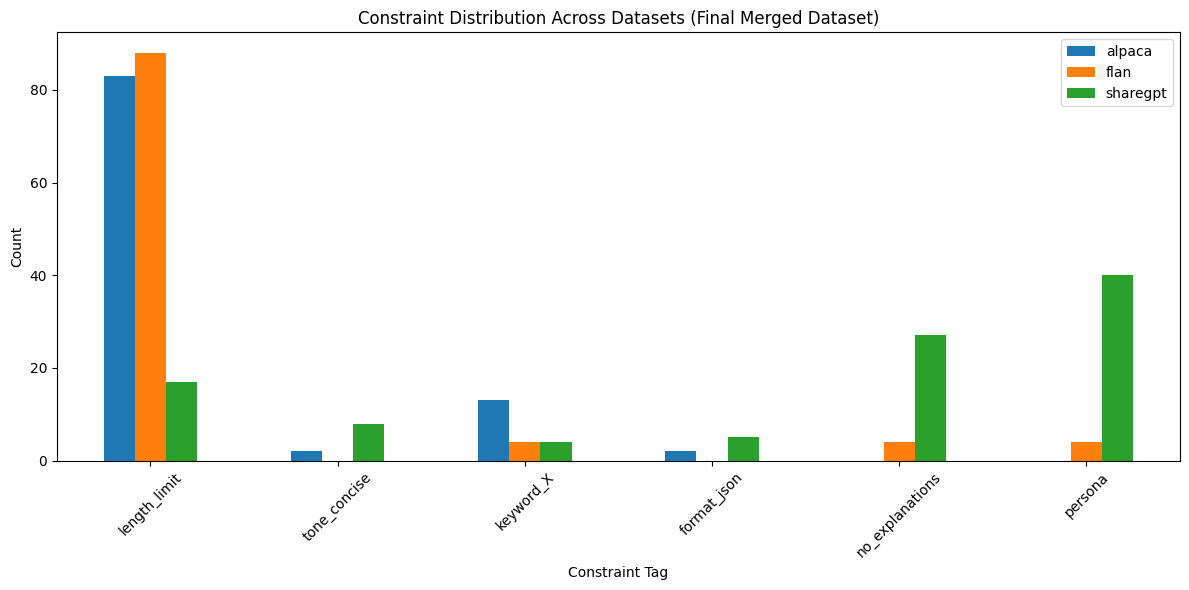

In [20]:
# ============================================
# Constraint distribution chart across datasets
# ============================================
import json
import pandas as pd
import matplotlib.pyplot as plt
from collections import Counter

MERGED_PATH = "merged_dataset_with_outputs.jsonl"

# Count constraints grouped by dataset
dataset_to_constraints = {
    "alpaca": Counter(),
    "flan": Counter(),
    "sharegpt": Counter()
}

with open(MERGED_PATH, "r", encoding="utf-8") as f:
    for line in f:
        obj = json.loads(line)
        ds = obj["dataset"]
        tags = obj.get("constraint_tags", [])
        dataset_to_constraints[ds].update(tags)

# Convert to DataFrame
df = pd.DataFrame(dataset_to_constraints).fillna(0).astype(int)

# Plot
df.plot(kind="bar", figsize=(12,6))
plt.title("Constraint Distribution Across Datasets (Final Merged Dataset)")
plt.xlabel("Constraint Tag")
plt.ylabel("Count")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()
